In [174]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from scipy.stats import norm

## **Contents**
- [Introduction](#introduction)
- [Structure of SDP](#structure-of-dynamic-programming-problems-with-randomness)
- [Marcov Process](#markov-process)
    - [Marcov Chain Simulation](#marcov-chain-simulation)
    - [Quantecon package](#simulation-by-quantecon)
    - [Marginal distribution](#marginal-distribution-of-each-state)
    - [Property](#properties-of-marcov-chain)
- [Stationary distribution](#stationary-distribution-of-marcov-chain)
    - [Theorem of existence](#theorem-1)
    - [Theorem of uniqueness](#theorem-2)
    - [Calculation](#calculating-stationary-distributions)
    - [Convergence](#convergence)
    - [Ergodicity](#ergodicity)
- [Expectations](#expectations)
- [Tauchen Method](#tauchens-method)
- [`quantecon.mc`](#attributes-of-marcov-chain-in-quantecon)


## **Introduction**

In previous lectures, we assumed that the state transition probability $Q(s,a,s')$ follows a Markov process. However, we did not justify the necessity of using a Markov process to model the randomness of state transitions.

This lecture will 
1. **outline the general structure of stochastic dynamic programming**.  
    We will see that without assuming the "Markov property" for state transitions, such problems become unsolvable.  

2. **introduce the concept of the Markov process and its characteristics.**  
    - The Markov process, with its memoryless property, reduces the computational burden when solving dynamic stochastic discrete programming (DSDP) problems. 
    - Moreover, we learn that a Markov chain satisfying some condition have unique stationary distribution and can be easily computed using simple algorithms.  

3. **learn Tauchen Method**  
    discuss how discrete Markov chains can be used to approximate AR(1) processes, allowing us to transform continuous processes into more manageable Markov processes.


## Structure of Dynamic Programming Problems with Randomness

- **State Space**: $\mathbb{S} \equiv \{x_1,x_2,...,x_N\}$
- **State Value**: $x_i \in \mathbb{S}$ 
- **Event**: $s_t \in \mathbb{S}$
- **Event History**: $s^t \equiv \{s_0,s_1,...,s_t\}$, where $s^t \in \underbrace{\mathbb{S} \times ... \times \mathbb{S}}_{t+1}$
- **Probability of an Event History**:  
    $$\pi_t(s^t) > 0, \forall s^t$$
    Notably,  
    $$ \pi_t(s^t) = 
        \mathbb{P}(s_0) \times \mathbb{P}(s_1 | s_0) \times \mathbb{P}(s_2 | s_0, s_1) \times ... \times \mathbb{P}(s_t | s_0, ..., s_{t-1}) 
    $$
    Even if the state space is finite, the complexity of the stochastic process of $s_t$ can make calculating the probability of an event history infeasible.
    
- **Policy Function**:
    $$\{c_t(s^t)\}_{t=0}^{\infty}, s^t \in \mathbb{S}^{t}$$
    
- **Discounted Reward (Value)**:
    $$ V \equiv \sum_{t=0}^{\infty} \sum_{s^t \in \mathbb{S}^t} \beta^t \pi_t(s^t) u(c_t(s^t)) $$


## Markov Process

The Markov process is a convenient stochastic process characterized by the Markov property (also known as the memoryless property), which simplifies the calculation of the probability of event histories.

- **Definition**:  
    A **Markov chain** $ \{s_t\} $ on $ S $ is a sequence of random variables on $ S $ that satisfies the **Markov property**.  
    This means that, for any time $ t $ and any state $ x \in S $,

    $$
    \mathbb{P} \{ s_{t+1} = x  \,|\, s_t \} = \mathbb{P} \{ s_{t+1}  = x \,|\, s_t, s_{t-1}, \ldots \}
    $$

- **Dynamics**:  
    The dynamics of a Markov chain are governed by the state transition probabilities:

    $$
    P(x_i, x_j) := \mathbb{P} \{ s_{t+1} = x_j \,|\, s_t = x_i \} 
    \quad (x_i, x_j \in \mathbb{S})
    $$

    By construction:
    1. $P(x_i, x_j)$ is the probability of transitioning from $x_i$ to $x_j$ in one step.
    2. $P(x, \cdot)$ represents the conditional distribution of $s_{t+1}$ given $s_t = x$.
    3. We can view $P$ as a stochastic matrix where
        $$
        P_{ij} = P(x_i, x_j) \quad (1 \leq i, j \leq n)
        $$

- **Stochastic Matrices**:  
    A **stochastic matrix** (or **Markov matrix**) is an $n \times n$ square matrix $P$ where:
    1. Each element of $P$ is nonnegative.
    2. Each row of $P$ sums to one.  
    Each row of $P$ can be interpreted as a probability mass function over $n$ possible outcomes.


#### **Marcov Chain Simulation**
If we take a stochastic matrix $ P $, we can generate a Markov chain $ \{s_t\} $ as follows:
1. draw $ s_0 $ from a marginal distribution $\psi_0$. 
1. for each $ t = 0, 1, \ldots $, draw $ s_{t+1} $ from $ P(s_t,\cdot) $  

To implement this simulation procedure, we need a method for generating draws from a discrete distribution.  
We use `random.draw` from `QuantEcon`, which works as follows:

In [175]:
ψ = (0.3, 0.7)           # probabilities over {0, 1}
cdf = np.cumsum(ψ)       # convert into cummulative distribution
qe.random.draw(cdf, 5)   # generate 5 independent draws from ψ

array([0, 1, 0, 0, 0])

A function that accepts the following three arguments:
- A stochastic matrix `P`  
- An initial state `init`  
- A positive integer `sample_size` representing the length of the time series  

In [176]:
def mc_sample_path(P, ψ_0=None, sample_size=1_000):
    
    # set up
    P = np.asarray(P)
    X = np.empty(sample_size, dtype=int)

    # Convert each row of P into a cdf
    n = len(P)
    P_dist = [np.cumsum(P[i, :]) for i in range(n)]

    # draw initial state, defaulting to 0
    if ψ_0 is not None:
        X_0 = qe.random.draw(np.cumsum(ψ_0))
    else:
        X_0 = 0

    # simulate
    X[0] = X_0
    for t in range(sample_size - 1):
        X[t+1] = qe.random.draw(P_dist[X[t]])

    return X

Let's see how it works:

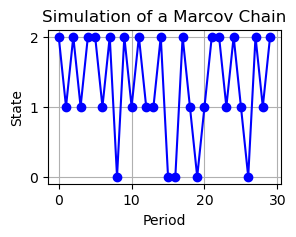

In [177]:
# Simulation
P = [[0.2, 0.2,0.6],
     [0.2, 0.1, 0.7],
     [0.3,0.6,0.1]]
X = mc_sample_path(P, ψ_0=[0.1, 0.1, 0.8], sample_size=30)

# Draw the graph
plt.figure(figsize=(3, 2))
plt.plot(X, marker='o', linestyle='-', color='b')
plt.title("Simulation of a Marcov Chain")
plt.xlabel("Period")
plt.ylabel("State")
plt.yticks([0,1,2])
plt.grid(True)
plt.show()

#### **Simulation by QuantEcon**

`QuantEcon` has packages for handling Markov chains, including simulation.  
**The state values can be integers, floats, or even strings.**  

In [178]:
P = [[0.4, 0.6],
     [0.2, 0.8]]

mc = qe.MarkovChain(P, state_values=('unemployed', 'employed'))

print('States:')
print(mc.simulate(ts_length=4, init='employed'))
print('Indices of states:')
print(mc.simulate_indices(ts_length=4))

States:
['employed' 'employed' 'employed' 'employed']
Indices of states:
[1 1 1 1]


### **Marginal Distribution of each state**

Suppose that  
1. $ \{s_t\} $ is a Markov chain with stochastic matrix $ P $  
1. the marginal distribution of $ s_t $ is known to be $ \psi_t $  


What then is the marginal distribution of $ s_{t+1} $, or, more generally, of $ s_{t+m} $?

To answer this, we let $ \psi_t $ be the marginal distribution of $ s_t $ for $ t = 0, 1, 2, \ldots $.

Our first aim is to find $ \psi_{t + 1} $ given $ \psi_t $ and $ P $.

To begin, pick any $ y  \in S $.

Using the [law of total probability](https://en.wikipedia.org/wiki/Law_of_total_probability), we can decompose the probability that $ s_{t+1} = y $ as follows:

$$
\mathbb P \{s_{t+1} = y \}
   = \sum_{x \in S} \mathbb P \{ s_{t+1} = y \, | \, s_t = x \}
               \cdot \mathbb P \{ s_t = x \}
$$

Rewriting this statement in terms of  marginal and conditional probabilities gives

$$
\psi_{t+1}(y) = \sum_{x \in S} P(x,y) \psi_t(x)
$$

There are $ n $ such equations, one for each $ y \in S $.

If we think of $ \psi_{t+1} $ and $ \psi_t $ as **row vectors**, then

<a id='equation-fin-mc-fr'></a>
$$
\psi_{t+1} = \psi_t P \tag{1}
$$

Thus, to move a marginal distribution forward one unit of time, we postmultiply by $ P $.

By postmultiplying $ m $ times, we move a marginal distribution forward $ m $ steps into the future.

Hence, iterating on [(1)](#equation-fin-mc-fr), the expression $ \psi_{t+m} = \psi_t P^m $ is also valid — here $ P^m $ is the $ m $-th power of $ P $.

As a special case, we see that if $ \psi_0 $ is the initial distribution from
which $ s_0 $ is drawn, then $ \psi_0 P^m $ is the distribution of
$ s_m $.

This is very important, so let’s repeat it


<a id='equation-mdfmc'></a>
$$
X_0 \sim \psi_0 \quad \implies \quad X_m \sim \psi_0 P^m \tag{2}
$$

and, more generally,


<a id='equation-mdfmc2'></a>
$$
X_t \sim \psi_t \quad \implies \quad X_{t+m} \sim \psi_t P^m \tag{3}
$$


<a id='finite-mc-mstp'></a>

### **Properties of Marcov Chain**

Let $ P $ be a fixed stochastic matrix.

#### **Communicate**:  
  Two states $ x $ and $ y $ are said to **communicate** with each other if
  there exist positive integers $ j $ and $ k $ such that

  $$
  P^j(x, y) > 0
  \quad \text{and} \quad
  P^k(y, x) > 0
  $$

  In view of our discussion above, this means precisely that  
  1. state $ x $ can eventually be reached  from state $ y $, and  
  1. state $ y $ can eventually  be reached from state $ x $  

#### **Irreducible**:  
  The stochastic matrix $ P $ is called **irreducible** if all states communicate:   
  if $ x $ and $ y $ communicate
  $ \forall (x, y) \in S \times S $.

- For example, consider the following transition probabilities for wealth of a fictitious set of households

  ![https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_irreducibility1.png](https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_irreducibility1.png)

  
  We can translate this into a stochastic matrix, putting zeros where
  there’s no edge between nodes

  $$
  P :=
  \left(
    \begin{array}{ccc}
       0.9 & 0.1 & 0 \\
      0.4 & 0.4 & 0.2 \\
      0.1 & 0.1 & 0.8
    \end{array}
  \right)
  $$

  It’s clear from the graph that this stochastic matrix is irreducible: we can  eventually
  reach any state from any other state.

  We can also test this using [QuantEcon.py](http://quantecon.org/quantecon-py)’s MarkovChain class

In [179]:
P = [[0.9, 0.1, 0.0],
     [0.4, 0.4, 0.2],
     [0.1, 0.1, 0.8]]

mc = qe.MarkovChain(P, ('poor', 'middle', 'rich'))
print(mc.is_irreducible)
print(mc.communication_classes)

True
[array(['poor', 'middle', 'rich'], dtype='<U6')]


- **Aperiodicity**:  
    A Markov chain is called **periodic** if it cycles in a predictable way, and **aperiodic** otherwise.  
    Formally, the **period** of a state $ x $ is the **largest common divisor** of a set of integers
    $$
    D(x) := \{j \geq 1 : P^j(x, x) > 0\}
    $$
    A stochastic matrix is called **aperiodic** if the period of every state is 1, and **periodic** otherwise.



    For example, the stochastic matrix associated with the transition probabilities below is periodic because, for example, state $ a $ has period 2

    ![https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_aperiodicity2.png](https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_aperiodicity2.png)

    We can confirm that the stochastic matrix is periodic:

In [180]:
P = [[0.0, 1.0, 0.0, 0.0],
     [0.5, 0.0, 0.5, 0.0],
     [0.0, 0.5, 0.0, 0.5],
     [0.0, 0.0, 1.0, 0.0]]

mc = qe.MarkovChain(P)
print(mc.period)
print(mc.is_aperiodic)

2
False


## **Stationary Distribution of Marcov Chain**

### **Stationary**:  
A marginal distribution $ \psi^* $ on $ S $ is called **stationary** for $ P $  
    If $ \psi^* = \psi^* P $.

### **Theorem 1.**  
If state space $\mathbb{S}$ is finite, every stochastic matrix $ P $ has at least one stationary distribution.  
    (Note that the distribution may not unique)


### **Theorem 2.**  
If $ P $ is **aperiodic and irreducible**, then  
    1. $ P $ has exactly one stationary distribution $ \psi^* $.  
    1. For any initial marginal distribution $ \psi_0 $, we have $ \| \psi_0 P^t - \psi^* \| \to 0 $ as $ t \to \infty $.  

- Note that:
    1. A stochastic matrix that satisfies the conditions of the theorem is called **uniformly ergodic**.
    2. A **sufficient condition for aperiodicity and irreducibility** is that  
        **every element of $ P $ is strictly positive**.


### **Calculating Stationary Distributions**


A particular Markov matrix $ P $ can have many stationary distributions.

That is, there can be many row vectors $ \psi $ such that $ \psi = \psi P $.

- If $ P $ has two distinct stationary distributions $ \psi_1,
    \psi_2 $ then it has infinitely many, since in this case, as you can verify,  for any $ \lambda \in [0, 1] $

    $$
    \psi_3 := \lambda \psi_1 + (1 - \lambda) \psi_2
    $$

    is a stationary distribution for $ P $.


- **If only one stationary distribution exists**, we can get stationary distribution by

    $$
    \psi (I_n - P) = 0 \tag{4}
    $$

    for $ \psi $, where $ I_n $ is the $ n \times n $ identity.

    But the zero vector solves system [(4)](#equation-eq-eqpsifixed),  so we must proceed cautiously.


- **Restrict $ \psi $ to  a probability distribution**  

    To achieve this, one option is to regard solving system [(4)](#equation-eq-eqpsifixed)  as an eigenvector problem:  
    A vector $ \psi $ such that $ \psi = \psi P $ is a left eigenvector associated with the unit eigenvalue $ \lambda = 1 $.

    Algorithm specialized for stochastic matrices is implemented in `QuantEcon`.

In [181]:
P = [[0.4, 0.6],
     [0.2, 0.8]]

mc = qe.MarkovChain(P)
print('The stationary distribution is:')
mc.stationary_distributions

The stationary distribution is:


array([[0.25, 0.75]])

### **Convergence**

**Theorem 2** tells us that the marginal distribution of $ s_t $ converges to the stationary distribution regardless of where we begin.

This adds considerable authority to our interpretation of $ \psi^* $ as a stochastic steady state.

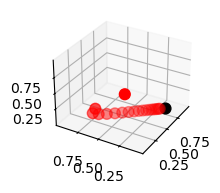

In [182]:
P = ((0.971, 0.029, 0.000),
     (0.145, 0.778, 0.077),
     (0.000, 0.508, 0.492))
P = np.array(P)
ψ = (0.0, 0.2, 0.8)        # Initial condition

# multiple probability matrix for many times
x_vals, y_vals, z_vals = [], [], []
for t in range(20):
    x_vals.append(ψ[0])
    y_vals.append(ψ[1])
    z_vals.append(ψ[2])
    ψ = ψ @ P

# Calculate stationary distribution
mc = qe.MarkovChain(P)
ψ_star = mc.stationary_distributions[0]


# Draw the figure
fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111, projection='3d')
ax.set(xlim=(0, 1), ylim=(0, 1), zlim=(0, 1),
       xticks=(0.25, 0.5, 0.75),
       yticks=(0.25, 0.5, 0.75),
       zticks=(0.25, 0.5, 0.75))
ax.scatter(x_vals, y_vals, z_vals, c='r', s=60)
ax.view_init(30, 210)

ax.scatter(ψ_star[0], ψ_star[1], ψ_star[2], c='k', s=60)
plt.show()

Here  
    - The highest red dot is an arbitrarily chosen initial marginal probability distribution  $ \psi $, represented as a vector in $ \mathbb R^3 $.  
    - The other red dots are the marginal distributions $ \psi P^t $ for $ t = 1, 2, \ldots $.  
    - The black dot is $ \psi^* $.

### **Ergodicity**

Under **irreducibility**, yet another important result obtains:


<a id='equation-llnfmc0'></a>
$$
\forall x \in \mathbb{S}, \quad
\frac{1}{m} \sum_{t = 1}^m \mathbf{1}\{s_t = x\}  \to \psi^*(x)
    \quad \text{as } m \to \infty \tag{5}
$$

Here

- $ \mathbf{1}\{s_t = x\} = 1 $ if $ s_t = x $ and zero otherwise  
- convergence is with probability one  
- the result does not depend on the marginal distribution  of $ s_0 $  


The result tells us that the fraction of time the chain spends at state $ x $ converges to $ \psi^*(x) $ as time goes to infinity.

This gives us another way to interpret the stationary distribution.

## **Expectations**

### **Unconditional expectation**
Expectations of functions of $ s_t $ is in the form

<a id='equation-mc-une'></a>
$$
\mathbb E [ h(s_t) ] \tag{6}
$$

where

- $ \{s_t\} $ is a Markov chain generated by $ n \times n $ stochastic matrix $ P $  
- $ h $ is a given function, which, in terms of matrix
  algebra, we’ll think of as the column vector  
$$
h
= \left(
\begin{array}{c}
    h(x_1) \\
    \vdots \\
    h(x_n)
\end{array}
  \right)
$$



We just sum over the marginal  distribution  of $ s_t $ to get

$$
\mathbb E [ h(s_t) ]
= \sum_{x \in \mathbb{S}} (\psi_0 P^t)(x) h(x)
$$

Here $ \psi_0 $ is the distribution of $ s_0 $.

**Since $ \psi_0 $ and hence $ \psi_0 P^t $ are row vectors**, we can also
write this as

$$
\mathbb E [ h(s_t) ]
=  \psi_0 P^t h
$$

### **Conditional Expectation**

<a id='equation-mc-cce'></a>
$$
\mathbb E [ h(s_{t + k})  \mid s_t = x] \tag{7}
$$

where

- $ \{s_t\} $ is a Markov chain generated by $ n \times n $ stochastic matrix $ P $  
- $ h $ is a given function, which, in terms of matrix
  algebra, we’ll think of as the column vector  


$$
h
= \left(
\begin{array}{c}
    h(x_1) \\
    \vdots \\
    h(x_n)
\end{array}
  \right)
$$



For the conditional expectation [(7)](#equation-mc-cce), we need to sum over
the conditional distribution of $ s_{t + k} $ given $ s_t = x $.

We already know that this is $ P^k(x, \cdot) $, so


<a id='equation-mc-cce2'></a>
$$
\mathbb E [ h(s_{t + k})  \mid s_t = x]
= (P^k h)(x) \tag{19.11}
$$

The vector $ P^k h $ stores the conditional expectation $ \mathbb E [ h(s_{t + k})  \mid s_t = x] $ over all $ x $.

## **Tauchen's Method**

In numerical work, it is necessary to replace a continuous model with a discrete one.

Markov chains are routinely generated as discrete approximations to AR(1) processes of the form

$$
y_{t+1} = \rho y_t + (1-\rho)\mu + u_{t+1}
$$

Here $ {u_t} $ is assumed to be IID and $ N(0, \sigma_u^2) $. $\mu$ is a constant.

The expectation value of $y_t$ is
$$
\mathbb{E}(y_{t+1}) = \rho \mathbb{E}(y_t) + (1-\rho)\mu \\
\mathbb{E}(y_{t+1}) = \mathbb{E}(y_t) \\
\mathbb{E}(y_t) = \mu
$$

The variance of the stationary probability distribution of $ \{ y_t \} $ is

$$
\mathbb{Var}(y_{t+1}) = \rho^2 \mathbb{Var}(y_{t}) + \mathbb{Var}(u_{t+1}) \\
\sigma_y^2 := \frac{\sigma_u^2}{1-\rho^2}
$$

**Tauchen’s method** (Tauchen, 1986) is the most common method for approximating this continuous state process with a finite state Markov chain.

1. As a first step, we choose  
- $ n $, the number of states for the discrete approximation  
- $ m $, an integer that parameterizes the width of the state space  


2. Next, we create a state space $ \{x_0, \ldots, x_{n-1}\} \subset \mathbb R $ and a stochastic $ n \times n $ matrix $ P $ such that
- $ x_0 = - m \, \sigma_y $  
- $ x_{n-1} = m \, \sigma_y $  
- $ x_{i+1} = x_i + s $ where $ s = (x_{n-1} - x_0) / (n - 1) $  


3. Let $ F $ be the cumulative distribution function of the normal distribution $ N(0, \sigma_u^2) $.

  The values $ P(x_i, x_j) $ are computed to approximate the AR(1) process — omitting the derivation, the rules are as follows:

  If $ j = 0 $, then set  
    $$
   P(x_i, x_j) = P(x_i, x_0) = F(x_0-\rho x_i + s/2)
    $$
  If $ j = n-1 $, then set  
    $$
    P(x_i, x_j) = P(x_i, x_{n-1}) = 1 - F(x_{n-1} - \rho x_i - s/2)
    $$
  Otherwise, set  
    $$
    P(x_i, x_j) = F(x_j - \rho x_i + s/2) - F(x_j - \rho x_i - s/2)
    $$


The exercise is to write a function `discretization_AR1(rho, mu, sigma_u, m=3, n=7)` that returns
$ \{x_0, \ldots, x_{n-1}\} \subset \mathbb R $ and $ n \times n $ matrix
$ P $ as described above.

- Even better, write a function that returns an instance of [QuantEcon.py’s](http://quantecon.org/quantecon-py) MarkovChain class.  

In [183]:
def discretization_AR1(ρ, μ, σ, N, d=3):
    """
    Tauchen Method
    Discretizes an AR(1) process with Gaussian shocks.

    Parameters:
    rho   : persistence parameter
    mu    : mean of the stochastic process
    sigma : standard deviation of the shocks (epsilon ~ N(0, sigma^2))
    N     : size of the discretized state space
    d     : deviation factor for state space bounds

    Returns:
    PI    : state transition matrix
    a_grid: grid of the state space
    """
    # Standard deviation of the stationary distribution
    σ_a = np.sqrt(σ**2 / (1 - ρ**2))
    
    # Define the boundaries of the state space
    a_min = μ - d * σ_a
    a_max = μ + d * σ_a
    
    # Discretized state space
    a_grid = np.linspace(a_min, a_max, N)
    
    # Prepare for probability computation
    m_list = (a_grid[:-1] + a_grid[1:]) / 2  # Midpoints
    
    # Initialize transition probability matrix
    PI = np.zeros((N, N))
    
    # Compute transition probabilities
    for i in range(N):
        # Probability for the first state
        PI[i, 0] = norm.cdf((m_list[0] - (1 - ρ) * μ - ρ * a_grid[i]) / σ)
        
        # Probability for the last state
        PI[i, N-1] = 1 - norm.cdf((m_list[-1] - (1 - ρ) * μ - ρ * a_grid[i]) / σ)
        
        # Probabilities for intermediate states
        for k in range(1, N-1):
            PI[i, k] = (norm.cdf((m_list[k] - (1 - ρ) * μ - ρ * a_grid[i]) / σ) -
                        norm.cdf((m_list[k-1] - (1 - ρ) * μ - ρ * a_grid[i]) / σ))
    
    return PI, a_grid

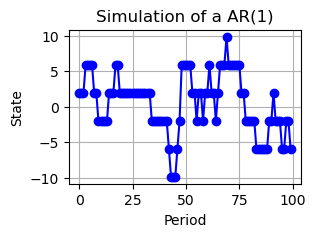

In [184]:
# apply the function
P,a_grid = discretization_AR1(ρ=0.9, μ=0, σ=2, N=8, d=3)

mc = qe.MarkovChain(P, state_values=a_grid)

X = mc.simulate(ts_length=100, init=a_grid[4])

# Draw the graph
plt.figure(figsize=(3, 2))
plt.plot(X, marker='o', linestyle='-', color='b')
plt.title("Simulation of a AR(1)")
plt.xlabel("Period")
plt.ylabel("State")
plt.grid(True)
plt.show()

Now, let's try the package of `quantecon`

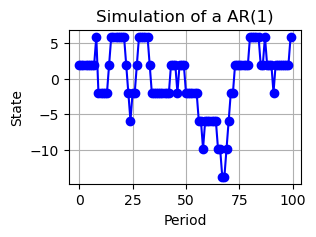

In [185]:
mc2 = qe.markov.approximation.tauchen(n=8, rho=0.9, sigma=2, mu=0.0, n_std=3)
grid=mc2.state_values

X2 = mc2.simulate(ts_length=100, init=grid[4])

# Draw the graph
plt.figure(figsize=(3, 2))
plt.plot(X2, marker='o', linestyle='-', color='b')
plt.title("Simulation of a AR(1)")
plt.xlabel("Period")
plt.ylabel("State")
plt.grid(True)
plt.show()

## Attributes of Marcov Chain in `quantecon`
see [quantecon.Marcov_Chain](https://quanteconpy.readthedocs.io/en/latest/markov/core.html#quantecon.markov.core.MarkovChain) for detail.

In [186]:
P = [[0.4, 0.6],
     [0.2, 0.8]]

mc = qe.MarkovChain(P, state_values=('a','b'))

print('\n Probability Matrix:')
print(mc.P)

print('\n Stationary Distribution:')
print(mc.stationary_distributions)

print('\n State Values:')
print(mc.state_values)

print('\n Simulation:')
print(mc.simulate(ts_length=5, init='a'))

print('\n Simulation for indices:')
print(mc.simulate_indices(ts_length=5, init=0))



 Probability Matrix:
[[0.4 0.6]
 [0.2 0.8]]

 Stationary Distribution:
[[0.25 0.75]]

 State Values:
['a' 'b']

 Simulation:
['a' 'a' 'a' 'a' 'b']

 Simulation for indices:
[0 1 1 1 0]
